# Loading Images Using tf.Data.Dataset

**Learning Objectives**

1. Retrieve Images using tf.keras.utils.get_file
2. Load Images using Keras Pre-Processing
3. Load Images using tf.Data.Dataset
4. Understand basic Methods for Training

## Introduction 

In this notebook, we load an image dataset using tf.data.  The dataset used in this example is distributed as directories of images, with one class of image per directory.


Each learning objective will correspond to a **#TODO** in the [student lab notebook](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/introduction_to_tensorflow/solutions/load_images_tf.data.ipynb) -- try to complete that notebook first before reviewing this solution notebook.

## Setup

## Load necessary libraries 
We will start by importing the necessary libraries for this lab.

In [1]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
print("TensorFlow version: ",tf.version.VERSION)

TensorFlow version:  2.6.3


In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

### Retrieve the images

Before you start any training, you will need a set of images to teach the network about the new classes you want to recognize. You can use an archive of creative-commons licensed flower photos from Google.

Note: all images are licensed CC-BY, creators are listed in the `LICENSE.txt` file.

In [3]:
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 2s 0us/step


After downloading (218MB), you should now have a copy of the flower photos available.

The directory contains 5 sub-directories, one per class:

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [5]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['daisy', 'tulips', 'dandelion', 'sunflowers', 'roses'],
      dtype='<U10')

Each directory contains images of that type of flower. Here are some roses:

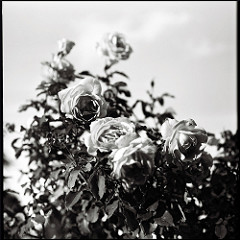

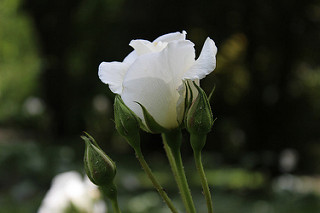

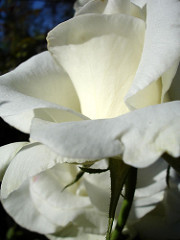

In [6]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

## Load using `keras.preprocessing`

A simple way to load images is to use `tf.keras.preprocessing`.

**Lab Task #1:** load your images using tf.keras.preprocessing.

In [9]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
# TODO 1a
# TODO -- Your code here.
image_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

Define some parameters for the loader:

In [10]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [11]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


In [20]:
train_data_gen.class_indices

{'daisy': 0, 'tulips': 1, 'dandelion': 2, 'sunflowers': 3, 'roses': 4}

Inspect a batch for image processing:

In [16]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
  # TODO 1b
        ax = plt.subplot(5, 5, n+1) # TODO -- Your code here.
      # TODO -- Your code here.
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

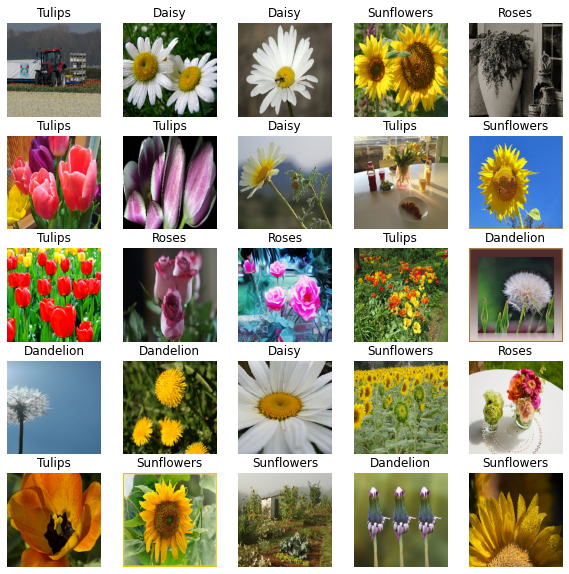

In [17]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

## Load using `tf.data`

The above `keras.preprocessing` method is convienient, but has three downsides: 

1. It's slow. See the performance section below.
1. It lacks fine-grained control.
1. It is not well integrated with the rest of TensorFlow.

To load the files as a `tf.data.Dataset` first create a dataset of the file paths:

In [21]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

2022-02-14 15:19:44.372773: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [22]:
for f in list_ds.take(5):
    print(f.numpy())

b'/home/jupyter/.keras/datasets/flower_photos/roses/8035908422_87220425d2_n.jpg'
b'/home/jupyter/.keras/datasets/flower_photos/sunflowers/45045005_57354ee844.jpg'
b'/home/jupyter/.keras/datasets/flower_photos/tulips/7205698252_b972087cc2.jpg'
b'/home/jupyter/.keras/datasets/flower_photos/roses/8060338380_eb6c806624_n.jpg'
b'/home/jupyter/.keras/datasets/flower_photos/dandelion/7295618968_c08a326cc1_m.jpg'


In [43]:
p=tf.strings.split(f,os.path.sep)

In [46]:
p

<tf.Tensor: shape=(8,), dtype=string, numpy=
array([b'', b'home', b'jupyter', b'.keras', b'datasets', b'flower_photos',
       b'dandelion', b'7295618968_c08a326cc1_m.jpg'], dtype=object)>

In [44]:
p[-2] == CLASS_NAMES

<tf.Tensor: shape=(5,), dtype=bool, numpy=array([False, False,  True, False, False])>

**Lab Task #2:** Write a short pure-tensorflow function that converts a file path to an `(img, label)` pair:

In [45]:
def get_label(file_path):
  # TODO 2a
  # convert the path to a list of path components
  # TODO -- Your code here.
    divisiones = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  # TODO -- Your code here.
    #img=parts[-1]
    #label=parts[-2]
    return divisiones[-2]==CLASS_NAMES

In [50]:
def decode_img(img):
  # TODO 2b
  # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
  # TODO -- Your code here.
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img=tf.image.convert_image_dtype(img,tf.float32)
  # TODO -- Your code here.
  # resize the image to the desired size.
    tf.image.resize(img, [200, 200])
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [48]:
def process_path(file_path):
    label = get_label(file_path)
  # TODO 2c
  # load the raw data from the file as a string
  # TODO -- Your code here.
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [51]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [52]:
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False False  True False False]


2022-02-14 15:35:06.009877: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


### Next Steps:  Basic methods for training

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be easily added using the `tf.data` api.

**Lab Task #3:** Adding features using the tf.data api. 

In [53]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  # TODO 3a
    if cache:
        if isinstance(cache, str):
              ds = ds.cache(cache)
    else:
        ds = ds.cache()

  # TODO -- Your code here.
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [54]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

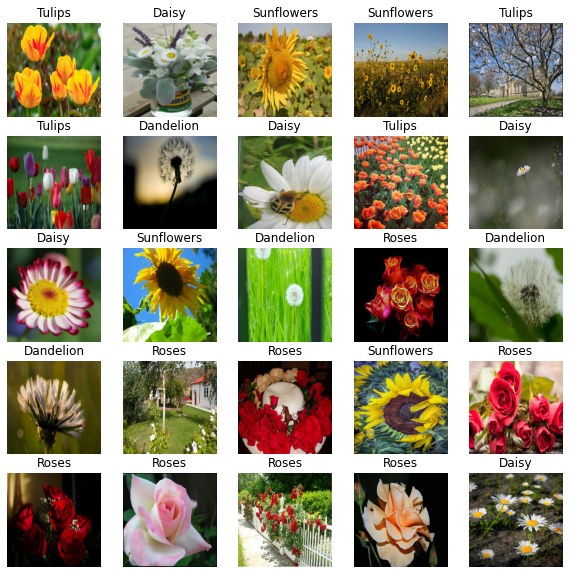

In [55]:
show_batch(image_batch.numpy(), label_batch.numpy())

Copyright 2020 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.